
## Natural Language Processing

Se desea contruir un detector de emociones con Redes Neuronales Recurrentes y Tensorflow.

**Conjunto de Datos**

[Emotion Detection from Text](https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text)

La detección de emociones a partir del texto es uno de los problemas desafiantes en el procesamiento del lenguaje natural. La razón es la dificultad para recopilar suficientes registros para cada emoción y, por lo tanto, surge el problema del desequilibrio de clases. El objetivo es construir un modelo eficiente para detectar emociones.

Los registros son básicamente una colección de tweets anotados con las emociones correspondientes. El dataset cuenta con tres columnas tweet_id, sentimient y content. En "contenido" tenemos el texto crudo. En "sentimiento" contamos con la emoción. 



#### Carga de Datos

In [1]:
pip install stylecloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.4/161.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259493 sha256=ad5db5bb53ce98473e07799ce091c7c81dbc4be1668b476b33b10665dd8c3277
  Stored in directory: /root/.cache/pip/wheels/aa/c8/27/9374f4fc7133015d902b5e2c75ad951edd57eb1ae948495915
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=25ba17b0f4e23774aa6a710be4a14221f4fe4cecf731089bb639cf55e37873d2
  Stored in directory: /root/.cache/pip

In [2]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd 
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy

import stylecloud
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import re
import os


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

from keras.utils import to_categorical



Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Redes_Neuronales/datasets/"

tweets = pd.read_csv(os.path.join(path, "tweet_emotions.csv"))

Al analizar brevemente el contenido que tiene la columna de 'content', vemos que nos encontraremos con varios problemas debido a que hay tweets que contienen:

- Menciones a otras cuentas

- Muchos signos de puntuacion

- Signos de admiración 

- Faltas de ortografía

- Contracciones

etc

In [4]:
tweets['content']

0        @tiffanylue i know  i was listenin to bad habi...
1        Layin n bed with a headache  ughhhh...waitin o...
2                      Funeral ceremony...gloomy friday...
3                     wants to hang out with friends SOON!
4        @dannycastillo We want to trade with someone w...
                               ...                        
39995                                     @JohnLloydTaylor
39996                       Happy Mothers Day  All my love
39997    Happy Mother's Day to all the mommies out ther...
39998    @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39999    @mopedronin bullet train from tokyo    the gf ...
Name: content, Length: 40000, dtype: object

En la siguiente línea de codigo podemos ver como es que se clasifican algunas de las palabras de algunos tweets:

In [5]:
for texto in tweets['content'][:10]:
    doc = nlp(texto)
    displacy.render(doc, style='ent', jupyter=True)

A continuación veremos un breve análisis de la cantidad que tweets que hay segun el sentimiento al que clasifican

In [6]:
aux = tweets.groupby('sentiment').count().reset_index()

In [7]:
import plotly.express as px
fig = px.bar(aux, x='sentiment', y='tweet_id', color='sentiment')
fig.show()

In [8]:
fig = px.pie(aux, values='tweet_id', 
             names='sentiment', 
             color='sentiment')
fig.show() 

Podemos observar que la base con la que estamos trabajando esta bastante desbalanceada pues tenemos una cantidad de tweets bastante considerable mayor en el sentimiento worry y neutral, mientras que tenemos muy pocos clasificados como anger, boredom, empty y enthusiasm, cosa que complicara el aprendizaje de nuestro modelo

En la siguiente imagen de nube de palabras podemos observar aquellas palabras con mayor frecuencia, distinguiendolas con un tamaño más grande que las demas.

In [9]:
stylecloud.gen_stylecloud(text=' '.join(tweets['content'].astype(str)),
                          palette="cartocolors.diverging.TealRose_7",
                          background_color='black',icon_name='fab fa-twitter')


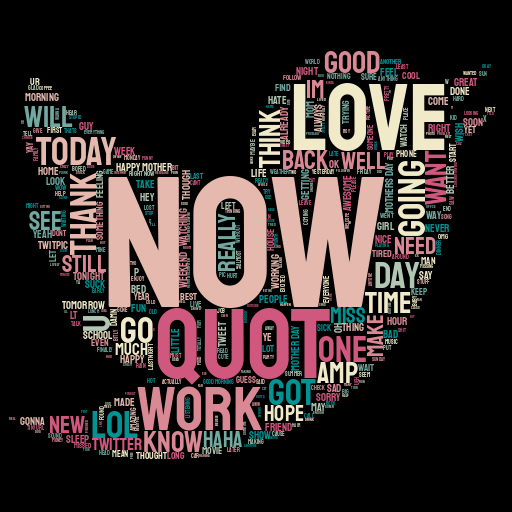

In [10]:
imagen = Image.open('stylecloud.png')
imagen.show()

#### Normalización del texto

Una buena idea seria agrupar los sentimientos en menos clases para no tener el desbalanceo de estas, usando **Word Embedding** podemos ver el parecido entre clases para dar una nueva clasificación

In [12]:
emb = pd.DataFrame()
emb.index = aux['sentiment']

In [13]:
for c in aux['sentiment']:
  emb[c] = 0

for c in aux['sentiment']:
  for d in aux['sentiment']:
    emb[c][d] = nlp(c).similarity(nlp(d))
fig = px.imshow(emb, color_continuous_scale = 'Blues')
fig.show()

In [14]:
tweets['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

Finalmente decicimos reducir la cantidad de sentimientos considerablemente agrupandlos en las siguientes 3 categorias:

In [15]:
positivas = ['happiness', 'fun', 'love', 'enthusiasm', 'surprise']
negativas =['boredom', 'worry', 'anger', 'hate', 'sadness', 'empty']
neutrales = ['relief', 'neutral']

In [16]:
tweets['label'] = 0

tweets.loc[tweets['sentiment'].isin(positivas),'label' ] = 'positivo'
tweets.loc[tweets['sentiment'].isin(negativas),'label' ] = 'negativo'
tweets.loc[tweets['sentiment'].isin(neutrales),'label' ] = 'neutro'

In [17]:
tweets['label'].value_counts()

negativo    16063
positivo    13773
neutro      10164
Name: label, dtype: int64

In [18]:
aux = tweets.groupby('label').count().reset_index()
fig = px.pie(aux, values='tweet_id', 
             names='label', 
             color='label')
fig.show() 

Podemos ver que nos sirvió bastante la re-categorización pues a pesar que que no tienen los mismos pesos, estos son mucho menos dispersos que los originales

Nube de palabras de aquellos tweets de sentimiento positivo:

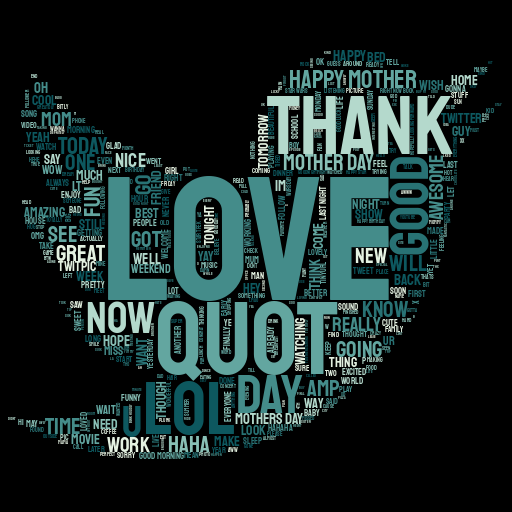

In [19]:
aux = tweets.loc[tweets['label']=='positivo']
stylecloud.gen_stylecloud(text=' '.join(aux['content'].astype(str)),
                          palette="cartocolors.sequential.Mint_7",
                          background_color='black',icon_name='fab fa-twitter',
                          output_name='Positive.png')

imagen = Image.open('Positive.png')
imagen.show()

Nube de palabras de aquellos tweets de sentimiento neutro:

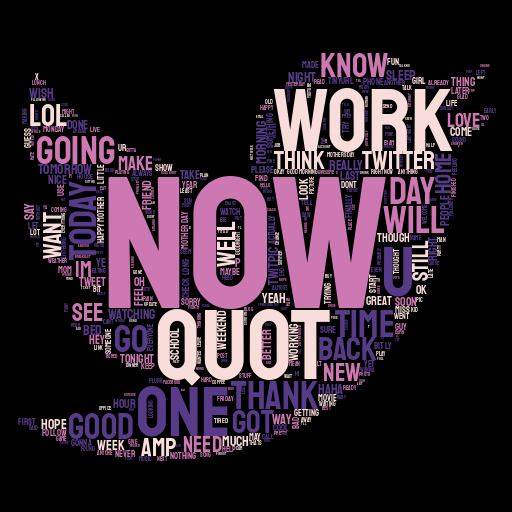

In [20]:
aux = tweets.loc[tweets['label']=='neutro']
stylecloud.gen_stylecloud(text=' '.join(aux['content'].astype(str)),
                          palette="cartocolors.sequential.PurpOr_3",
                          background_color='black',icon_name='fab fa-twitter',
                          output_name='Neutral.png')

imagen = Image.open('Neutral.png')
imagen.show()

Nube de palabras de aquellos tweets de sentimiento negativo

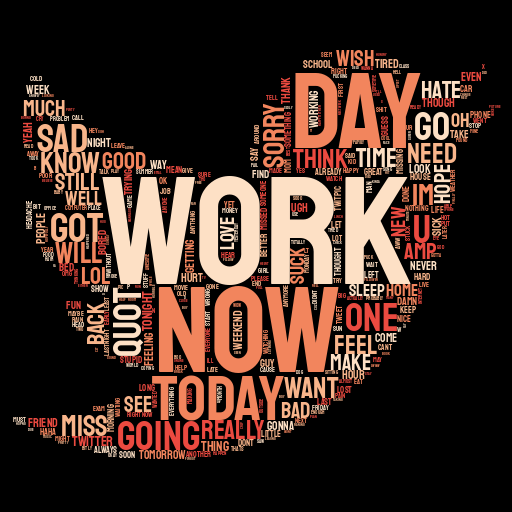

In [21]:
aux = tweets.loc[tweets['label']=='negativo']
stylecloud.gen_stylecloud(text=' '.join(aux['content'].astype(str)),
                          palette="cartocolors.sequential.Peach_4",
                          background_color='black',icon_name='fab fa-twitter',
                          output_name='Negative.png')

imagen = Image.open('Negative.png')
imagen.show()

Ya con las clases agrupadas de mejor manera procedemos a limpiar los comentarios para mejorar el performance de nuestro modelo



Quitamos los @usuarios, ya que son palabras que podrian ensuciar el modelo

In [ ]:
df = tweets.copy()

In [ ]:
def arroba(x):
  y = x.split(' ')
  z = [i for i in y if len(i) > 0  and i[0]!='@']
  z = ' '.join(z)
  return z

In [ ]:
#df.loc[df['content'].str.contains('@'), 'content'] = df.loc[df['content'].str.contains('@')]['content'].map(arroba)

Quitamos las **stop words** pues son palabras que unicamente meter ruido al modelo sin proporcionar información

In [ ]:
print(nlp.Defaults.stop_words)

{'several', 'a', 'in', 'others', 'somewhere', 'there', 'none', 'n‘t', 'he', 'are', 'anything', 'wherein', 'themselves', '‘re', 'must', 'five', 'not', 'thereby', 'own', 'become', 'below', 'throughout', 'whether', 'whither', 'to', 'out', 'them', 'do', 'now', 'have', 'where', 'as', 'eight', 'seem', 'very', 'else', 'done', 'thru', 'seeming', 'latter', 'made', 'under', 'per', 'ourselves', 'three', 'should', 'please', 'or', 'being', 'sixty', 'an', 'show', 'me', 'had', '’m', 'thereupon', 'who', 'hereupon', 'its', 'yours', 'hers', 'towards', 'full', 'within', 'except', 'perhaps', 'been', '’re', 'otherwise', 'one', 'while', 'get', 'after', 'side', 'when', 'whereafter', 'around', 'always', 'up', 'still', "'ll", 'nobody', 'you', 'other', 'of', 'indeed', 'herein', '‘ve', 'afterwards', 'fifty', 'hundred', 'were', 'therefore', "'m", 'which', 'see', 'everything', 'everywhere', 'hereafter', '‘ll', 'us', 'above', 'forty', 'part', 'anyone', 'will', 'toward', 'anyhow', 'bottom', 'mostly', 'my', 'along', 

In [ ]:
stop_words = list(nlp.Defaults.stop_words)

In [ ]:
def stopwords(x):
  y = x.split(' ')
  z = [i for i in y if i not in stop_words ]
  z = ' '.join(z)
  return z 

In [ ]:
#df['content'] = df['content'].map(stopwords)

Tambien quitaremos signos de puntuación o elementos que no sean de una palabra

In [ ]:
punctuations = [token.text for token in nlp.vocab if token.is_punct]
punctuations = list(set(list(''.join(punctuations))))
punctuations += ['=','<','>','+']

In [ ]:
def puntuacion(x):
  y = nlp(x)
  z = ""
  for token in y:
      if not token.is_punct:
          z += token.text + " "

  for c in punctuations:
    z = z.replace(c,'')
  return z


In [ ]:
#df['content'] = df['content'].map(puntuacion)

Ahora haremos una **lematización** de las palabras en content para regresar las palabras a su forma original (en caso de ser un verbo a infinitivo)

In [ ]:
def lema(x):
  y = nlp(x)
  z = []
  for token in y:
    z.append(token.lemma_)

  z = ' '.join(z)
  return z 

In [ ]:
%%time
#df['content'] = df['content'].map(lema)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


Definimos una ultima limpueza al texto final donde convertiremos el texto a minusculas, eliminaremos ligas que inicien con http:// o https://, que inicien con www. y terminen con .com, caracteres de referencia HTML, numeros, etc.

In [ ]:
def clean_text(text):
    # Convertir a minúsculas
    clean_text = text.lower()
    
    # Remover links que inician con http:// o https://
    clean_text = re.sub(r'https?:\/\/\S+', ' ', clean_text)
    
    # Remover links que conmienzan con www. y terminan con .com
    clean_text = re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)|www', ' ', clean_text)

    # Remover caracteres de referencia HTML
    clean_text = re.sub(r'&[a-z]+;', ' ', clean_text)

    # Elimina aquello que no sean letras del abecedario, espacios, parentesis, guiones, dos puntos, barras inclinadas, punto y coma, =, #, ':
    clean_text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", ' ', clean_text)

    # Elimina los numeros que puedan estar':
    for c in ['1','2','3','4','5','6','7','8','9','0','*','+']:
      clean_text = clean_text.replace(c,'')

    #Convertir cada tweet en una lista de palabras
    clean_text = clean_text.split()    
    lista = []
    for token in clean_text:
      if len(token)>1:
        lista.append(token)
    
    clean_text = ' '.join(lista)
        


    return clean_text


**Definimos una funcion que incluya las demas funciones de limpieza para tener todo de manera automatizada** 

In [ ]:
def limpieza_texto(x):
  y = clean_text(lema(puntuacion(stopwords(arroba(x)))))
  if y =='':
    y = 'Null'
  return y

Aplicamos la función de limpieza a los tweets:

In [ ]:
%%time
df['clean_content'] = df['content'].map(limpieza_texto)

CPU times: user 10min 9s, sys: 1.77 s, total: 10min 10s
Wall time: 10min 31s


Verificamos que no existan valores nulos en nuestra data:

In [ ]:
df.isna().sum()

tweet_id         0
sentiment        0
content          0
label            0
clean_content    0
dtype: int64

Ahora localizaremos aquellos tweets que debido a la limpieza aplicada, se les asigno como contenido "Null", para etiquetarlos como sentimiento neutro

In [ ]:
df.loc[df['clean_content']=='Null']['label'].value_counts()

neutro    185
Name: label, dtype: int64

In [ ]:
df.loc[df['clean_content']=='Null', 'label'] = 'neutro'

In [ ]:
df = df[['tweet_id', 'sentiment', 'content',
       'label', 'clean_content']]

Guardamos nuestro data en un csv para no tener que correr todo el proceso en futuras ocasiones donde tengamos que correr el codigo

In [ ]:
#df.to_csv(os.path.join(path, 'data_lematizada.csv'), index=False)

In [ ]:
df = pd.read_csv(os.path.join(path, "data_lematizada.csv"))

Nos damos cuenta que hay tweets que son identicos pero tienen una catalogación de sentimiento diferencite, por lo que a estos casos, les asignaremos la etiquetaremos con el sentimiento de mayor frecuencia del tweet

In [ ]:
pt1 = df.pivot_table(index='clean_content', values='tweet_id',columns='label', aggfunc='count').reset_index().fillna(0)
pt2 = df.pivot_table(index='clean_content', values='label', aggfunc=pd.Series.nunique ).reset_index().fillna(0)
pt = pt1.merge(pt2, on='clean_content', how='inner')
pt = pt.sort_values('label', ascending=False).reset_index(drop=True)
pt

,clean_content,negativo,neutro,positivo,label
0,hey,1.0,2.0,1.0,3
1,happy mother day mom,1.0,3.0,12.0,3
2,thank,12.0,43.0,35.0,3
3,friday night,1.0,1.0,1.0,3
4,hug,1.0,1.0,2.0,3
...,...,...,...,...,...
38510,have not talk day school that right,1.0,0.0,0.0,1
38511,have not time twitter work time,1.0,0.0,0.0,1
38512,have not tweet like day go,0.0,1.0,0.0,1
38513,have not twitter awhile bgt drawing summer finals,0.0,0.0,1.0,1


In [ ]:
aux = pt.loc[pt['label']>1].reset_index(drop=True)
for c in range(len(aux)):
  neg = aux['negativo'][c]
  neu = aux['neutro'][c]
  pos = aux['positivo'][c]
  if neg==neu and neu==pos:
    df.loc[df['clean_content']==aux['clean_content'][c],'label'] = 'neutro'
  else:
    label_dict = dict(zip([neg,neu,pos],['negativo','neutro','positivo'] ))
    maximo = max(neg,neu,pos)
    df.loc[df['clean_content']==aux['clean_content'][c],'label'] = label_dict[maximo]


In [ ]:
label_dict

{1.0: 'negativo', 2.0: 'neutro', 0.0: 'positivo'}

In [ ]:
df.pivot_table(index='clean_content', values='label', aggfunc=pd.Series.nunique ).reset_index().fillna(0).sort_values('label')

,clean_content,label
0,Null,1
25673,rain rain rain away come week go via rain lie ...,1
25674,rain rain rain wow actually love rain,1
25675,rain right car wash,1
25676,rain stop minute ago notice time cheer rain it...,1
...,...,...
12839,have nice pre mother day dinner out now cockta...,1
12840,have nice sunday xx,1
12841,have nice thing time kinda fun teeheeand ll halo,1
12843,have nice weather prague,1


In [ ]:
#df.to_csv(os.path.join(path, 'data_lematizada.csv'), index=False)

In [ ]:
df = pd.read_csv(os.path.join(path, "data_lematizada.csv"))

In [ ]:
df = df[['tweet_id', 'label', 'clean_content']].drop_duplicates().reset_index(drop=True)


#### Arquitecturas Basadas en Redes Neuronales

Se definiran 3 redes neuroanles recurrentes con el uso de Tensorflow. Los diseños de las arquitecturas hacen el uso de capas RNN, LSTM, GRU o Bidireccionales

##### Tokenizacion

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 1000
oov_tok = '<OOV>'
padding_type = 'post'

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['clean_content'])
word_index = tokenizer.word_index

In [ ]:
vocab_size = len(word_index)
vocab_size

28779

In [ ]:
tokenized_reviews = tokenizer.texts_to_sequences(df['clean_content'])
max_length = max([len(x) for x in tokenized_reviews])
padded_reviews = pad_sequences(tokenized_reviews, maxlen=max_length, padding=padding_type)

In [ ]:
label_dict = dict(zip(list(df['label'].unique()), [0,1,2]))
label_dict

{'negativo': 0, 'positivo': 1, 'neutro': 2}

In [ ]:
labels = df['label'].map(label_dict)

In [ ]:
labels

0        0
1        0
2        0
3        1
4        2
        ..
39995    2
39996    1
39997    1
39998    1
39999    1
Name: label, Length: 40000, dtype: int64

In [ ]:
from keras.utils import to_categorical

one_hot_labels = to_categorical(labels, num_classes=3)

In [ ]:
one_hot_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

##### Word Embeddings

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

In [ ]:
log_directory = "/content/drive/MyDrive/Redes_Neuronales/models/"
tensorboard = TensorBoard(log_dir=log_directory, histogram_freq=1, write_graph=True, update_freq='epoch')
ckpt = ModelCheckpoint(filepath='tweet_model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size+1, output_dim=20, input_length=max_length)

##### Modelo 01


Creamos el primero modelo que tiene una capa de incrustación para representar las palabras en un espacio vectorial denso.

La tercera línea agrega una capa SimpleRNN con 64 unidades que utiliza una red neuronal recurrente para procesar la secuencia de entrada. 

La cuarta línea agrega una capa Dropout con una tasa de dropout del 25%. Esta capa se utiliza para reducir el sobreajuste al "apagar" aleatoriamente algunos de los nodos de la capa anterior.

La quinta línea agrega una capa de aplanamiento para la salida de la capa anterior.

Finalmente, la sexta línea agrega una capa densa con una activación softmax que produce una salida de 3 dimensiones para la clasificación multiclase.

In [ ]:
model01 = Sequential()
model01.add(embedding_layer)
model01.add(SimpleRNN(units=64))
model01.add(Dropout(0.25))
model01.add(Flatten())
model01.add(Dense(3, activation='softmax'))

model01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 20)            575600    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                5440      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 581,235
Trainable params: 581,235
Non-trainable params: 0
_________________________________________________________________


##### Modelo 02


La diferencia entre este y el anterior modelo es que el primero utiliza una capa SimpleRNN, que es una de las capas recurrentes más simples y básicas. Esta capa permite que el modelo tenga en cuenta la secuencia de entrada y las dependencias temporales entre las palabras, pero puede tener dificultades para aprender dependencias a largo plazo

In [ ]:
from tensorflow.keras.layers import GRU,Reshape

model02 = Sequential()
model02.add(embedding_layer)
model02.add(GRU(units=64, activation='tanh'))
model02.add(Dropout(0.25))
model02.add(Flatten())
model02.add(Dense(3, activation='softmax'))

model02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 20)            575600    
                                                                 
 gru (GRU)                   (None, 64)                16512     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 592,307
Trainable params: 592,307
Non-trainable params: 0
_________________________________________________________________


##### Modelo 03

En este caso, se utiliza una capa LSTM (Memoria a largo plazo) en lugar de SimpleRNN o GRU. La capa LSTM también utiliza puertas para controlar el flujo de información, al igual que la capa GRU, pero tiene una estructura más compleja que le permite recordar información a largo plazo. 

In [ ]:
from tensorflow.keras.layers import LSTM

model03 = Sequential()
model03.add(embedding_layer)
model03.add(LSTM(units=64, activation='tanh'))
model03.add(Dropout(0.25))
model03.add(Flatten())
model03.add(Dense(3, activation='softmax'))


model03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model03.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 20)            575600    
                                                                 
 lstm (LSTM)                 (None, 64)                21760     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 597,555
Trainable params: 597,555
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento y Optimizacion de los modelos hasta encontrar el mejor de estos

##### Modelo 01

In [ ]:
log_directory = "/content/drive/MyDrive/Redes_Neuronales/models/"
tensorboard = TensorBoard(log_dir=log_directory, histogram_freq=1, write_graph=True, update_freq='epoch')
ckpt = ModelCheckpoint(filepath='tweet_model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
results01 = model01.fit(padded_reviews, one_hot_labels, epochs=100, validation_split=.2, verbose=1, callbacks=[early_stop, tensorboard, ckpt])

Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5243
Epoch 1: val_loss improved from inf to 1.00698, saving model to tweet_model.01-1.01.h5
1000/1000 [==============================] - 20s 18ms/step - loss: 0.9863 - accuracy: 0.5242 - val_loss: 1.0070 - val_accuracy: 0.5217
Epoch 2/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.9328 - accuracy: 0.5669
Epoch 2: val_loss improved from 1.00698 to 0.93398, saving model to tweet_model.02-0.93.h5
1000/1000 [==============================] - 17s 17ms/step - loss: 0.9327 - accuracy: 0.5669 - val_loss: 0.9340 - val_accuracy: 0.5692
Epoch 3/100
 997/1000 [============================>.] - ETA: 0s - loss: 0.9027 - accuracy: 0.5881
Epoch 3: val_loss did not improve from 0.93398
1000/1000 [==============================] - 17s 17ms/step - loss: 0.9027 - accuracy: 0.5881 - val_loss: 0.9783 - val_accuracy: 0.5301
Epoch 4/100
1000/1000 [==============================] - ETA: 0s - loss: 

In [ ]:
the_best01 = 'tweet_model.02-0.93.h5' 

In [ ]:
model01.load_weights(the_best01)

In [ ]:
#model01.save("/content/drive/MyDrive/Redes_Neuronales/models/Twitter_Model01.h5")

El modelo que se describe tiene una precisión de entrenamiento del 56.69% y una pérdida de 0.9327. Esto significa que durante el entrenamiento del modelo, el 56.69% de las predicciones que hizo fueron correctas.

El modelo también tiene una precisión de validación del 56.92% y una pérdida de validación de 0.9340. Esto significa que cuando se evaluó el modelo en un conjunto de datos de validación separado, el modelo tuvo una precisión del 56.92%

##### Modelo 02

In [ ]:
log_directory = "/content/drive/MyDrive/Redes_Neuronales/models/"
tensorboard = TensorBoard(log_dir=log_directory, histogram_freq=1, write_graph=True, update_freq='epoch')
ckpt = ModelCheckpoint(filepath='tweet_model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=False)

In [ ]:
results02 = model02.fit(padded_reviews, one_hot_labels, epochs=100, validation_split=.2, verbose=1, callbacks=[early_stop, tensorboard, ckpt])

Epoch 1/100
 998/1000 [============================>.] - ETA: 0s - loss: 1.0491 - accuracy: 0.4691
Epoch 1: saving model to tweet_model.01-0.97.h5
1000/1000 [==============================] - 25s 23ms/step - loss: 1.0486 - accuracy: 0.4695 - val_loss: 0.9693 - val_accuracy: 0.5251
Epoch 2/100
 998/1000 [============================>.] - ETA: 0s - loss: 0.9130 - accuracy: 0.5778
Epoch 2: saving model to tweet_model.02-0.91.h5
1000/1000 [==============================] - 24s 24ms/step - loss: 0.9129 - accuracy: 0.5779 - val_loss: 0.9075 - val_accuracy: 0.5869
Epoch 3/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.8840 - accuracy: 0.5961
Epoch 3: saving model to tweet_model.03-0.91.h5
1000/1000 [==============================] - 22s 22ms/step - loss: 0.8840 - accuracy: 0.5962 - val_loss: 0.9110 - val_accuracy: 0.5825
Epoch 4/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.8735 - accuracy: 0.6042
Epoch 4: saving model to tweet_model.04-0.93.h5
1000/10

In [ ]:
the_best02 = 'tweet_model.03-0.91.h5' #trai_accuracy:0.59 | val_accuracy:0.58

In [ ]:
model02.load_weights(the_best02)

In [ ]:
#model02.save("/content/drive/MyDrive/Redes_Neuronales/models/Tweeter_Model02.h5")

El modelo también tiene una precisión de validación del 58.25% y una pérdida de validación de 0.9110. Esto significa que cuando se evaluó el modelo en un conjunto de datos de validación separado, el modelo tuvo una precisión del 58.25% en este conjunto de datos

##### Modelo 03

In [ ]:
log_directory = "/content/drive/MyDrive/Redes_Neuronales/models/"
tensorboard = TensorBoard(log_dir=log_directory, histogram_freq=1, write_graph=True, update_freq='epoch')
ckpt = ModelCheckpoint(filepath='tweet_model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
results03 = model03.fit(padded_reviews, one_hot_labels, epochs=100, validation_split=.2, verbose=1, callbacks=[early_stop, tensorboard, ckpt])

Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.9190 - accuracy: 0.5760
Epoch 1: val_loss improved from inf to 0.91004, saving model to tweet_model.01-0.91.h5
1000/1000 [==============================] - 30s 28ms/step - loss: 0.9189 - accuracy: 0.5762 - val_loss: 0.9100 - val_accuracy: 0.5904
Epoch 2/100
 998/1000 [============================>.] - ETA: 0s - loss: 0.8869 - accuracy: 0.6012
Epoch 2: val_loss improved from 0.91004 to 0.90719, saving model to tweet_model.02-0.91.h5
1000/1000 [==============================] - 26s 26ms/step - loss: 0.8868 - accuracy: 0.6012 - val_loss: 0.9072 - val_accuracy: 0.5847
Epoch 3/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.8755 - accuracy: 0.6056
Epoch 3: val_loss did not improve from 0.90719
1000/1000 [==============================] - 27s 27ms/step - loss: 0.8756 - accuracy: 0.6056 - val_loss: 0.9324 - val_accuracy: 0.5835
Epoch 4/100
 999/1000 [============================>.] - ETA: 0s - loss: 

In [ ]:
the_best03 = 'tweet_model.01-0.89.h5' 

In [ ]:
model03.load_weights(the_best03)

In [ ]:
#model03.save("/content/drive/MyDrive/Redes_Neuronales/models/Tweeter_Model03.h5")

##### Valuación de los modelos

In [ ]:
best_model = load_model("/content/drive/MyDrive/Redes_Neuronales/models/Tweeter_Model02.h5")

In [ ]:
probs_predictions = best_model.predict_generator(padded_reviews)
probs_predictions 

array([[0.64062005, 0.16826324, 0.19111674],
       [0.805411  , 0.07960214, 0.11498685],
       [0.4362112 , 0.18896809, 0.3748208 ],
       ...,
       [0.10730248, 0.7815865 , 0.11111093],
       [0.2842321 , 0.5517257 , 0.16404212],
       [0.47047725, 0.23846558, 0.29105717]], dtype=float32)

In [ ]:
import numpy as np
predictions = np.argmax(probs_predictions, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(labels,predictions))

              precision    recall  f1-score   support

           0       0.60      0.78      0.68     15892
           1       0.65      0.60      0.63     13819
           2       0.52      0.35      0.42     10289

    accuracy                           0.61     40000
   macro avg       0.59      0.58      0.57     40000
weighted avg       0.60      0.61      0.59     40000



#### Visualización en dos dimensiones

In [ ]:
import pandas as pd
from scipy import spatial

In [ ]:
cosine_similarity = lambda x, y: 1 - spatial.distance.cosine(x, y)

In [ ]:
print(embedding_layer.get_weights()[0].shape)

(48999, 20)


In [ ]:
Embedding = pd.DataFrame((embedding_layer.get_weights()[0]), index=['<pad>']+list(word_index.keys()), columns=['dim_'+str(x) for x in range(1,21)])

In [ ]:
Embedding

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20
<pad>,0.035901,-0.011775,0.010267,0.011858,0.008070,-0.014227,-0.022164,-0.015999,-0.046005,-0.014383,0.028964,0.016737,0.085941,0.096495,0.047528,0.004719,0.020898,0.032371,0.030048,-0.032948
<OOV>,-0.022020,-0.084498,0.046919,-0.048233,-0.074478,0.056790,0.035603,0.086469,0.074304,-0.020223,-0.070331,0.072161,-0.054977,-0.017334,0.043125,-0.033477,-0.153132,0.063502,0.004268,0.021427
i,-0.152705,0.067929,-0.075608,-0.142136,0.043713,-0.092655,0.202316,-0.028932,-0.044727,0.300841,-0.006772,-0.111871,-0.066670,-0.256025,-0.005925,-0.090831,0.188496,-0.047403,-0.163148,0.254352
to,0.157732,-0.188089,0.014264,-0.032812,-0.103207,-0.063344,0.139263,0.077521,0.059246,-0.057381,0.027061,0.182848,-0.010170,0.087367,0.029256,-0.020407,-0.142424,-0.071110,-0.023616,0.055969
the,0.202484,-0.092878,-0.077238,0.040604,-0.135190,0.011413,-0.021546,0.047400,0.010002,-0.151558,-0.216959,0.001061,-0.096206,0.013749,-0.104743,-0.028939,-0.266485,-0.300568,-0.042840,0.009948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
'momma',0.005295,0.021119,0.006549,-0.024884,-0.017611,-0.028718,-0.039505,0.000702,-0.047601,-0.037618,0.015694,-0.010457,-0.005316,0.048764,0.003380,0.023653,-0.033376,0.016310,0.006201,0.038634
ipsohot,0.038339,-0.039030,0.011712,-0.029092,0.018707,0.029534,0.008443,0.012345,0.044649,0.025987,0.013667,-0.034213,0.003460,0.027628,-0.016913,-0.045980,-0.012080,0.017951,-0.040638,0.004461
sightseeing,0.000728,-0.008059,-0.022302,-0.037892,0.044580,0.033823,0.023047,0.035391,0.000279,0.046115,-0.040481,0.037477,0.037538,0.016284,-0.001338,0.017355,0.009953,-0.043792,0.038982,-0.044129
gaijin,-0.042605,-0.014874,-0.001168,0.019923,0.001997,0.026474,0.042558,-0.041921,-0.022215,0.017850,-0.009203,-0.006064,-0.004966,0.029122,-0.014592,0.024492,0.038470,-0.031441,0.022822,0.015963


##### PCA

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

In [ ]:
pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(Embedding))

In [ ]:
X_pca.columns=["componente_1","componente_2"]
X_pca["labels"]=df['label'] 

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = px.scatter(X_pca, x="componente_1", y="componente_2", color="labels",title='PCA')
fig.show()

##### TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = pd.DataFrame(tsne.fit_transform(Embedding))

In [ ]:
X_tsne.columns=["componente_1","componente_2"]
X_tsne["labels"]=df['label']

In [ ]:
fig = px.scatter(X_tsne, x="componente_1", y="componente_2", color="labels",title='TSNE')
fig.show()

Es facil ver que no es sencillo de separar los datos, pues a pesar de que se re-categorizaron en unicamente 3, el modelo no es el mejor, por lo que la separación de datos tampoco será clara.

#### Aplicación del Modelo

In [ ]:
label_dict = {'negativo': 0, 'positivo': 1, 'neutro': 2} 
inverted_label_dict = {v: k for k, v in label_dict.items()}
print(inverted_label_dict)

{0: 'negativo', 1: 'positivo', 2: 'neutro'}


In [ ]:
tweets_prueba = ['Excited to announce that I’ve hired a new CEO for X/Twitter. She will be starting in ~6 weeks!',
                 'Sorry our video upload is so bad! We’re working on major improvements.',
                 'Such a great day in so many ways',
                 'And sometimes a discussion on Spaces',
                 'Impersonating others is wrong!','Happy Easter!',
                 'Friendship takes work, enmity is effortless',
                 'If you don’t like reality, just ignore it',
                 'It’s exciting to see more & more public figures engaging in active dialogue on this platform!',
                 'The world is threatened by my power and my stamina',
                 'not terrible',
                 'You’re terrible & I love you',
                 'I have been working on myself and it feels amazing',
                 'I had a bad day today, my cat died',
                 'A positive mindset is healthy',
                 'I am so poor that I have everything',
                 'Never stop learning',
                 'I am so excited because mañana I am going to go to travel',
                 'I like you better than chocolate chip cookies',
                 'They are more unpleasant than looking at the sun','Love is not a safe word',
                 'Love is a cute word','shining brighter than all the stars in the sky']

In [ ]:
tokenized_reviews = tokenizer.texts_to_sequences(df['clean_content'])
max_length = max([len(x) for x in tokenized_reviews])

tweets_val = pd.Series(tweets_prueba).map(limpieza_texto)
tokenized_val = tokenizer.texts_to_sequences(tweets_val)
max_length = max([len(x) for x in tokenized_reviews])
paddedd_validation = pad_sequences(tokenized_val, maxlen=max_length, padding=padding_type)

In [ ]:
best_model = load_model("/content/drive/MyDrive/Redes_Neuronales/models/Tweeter_Model02.h5")
probs_predictions = best_model.predict_generator(paddedd_validation)

In [ ]:
import numpy as np 
predictions = np.argmax(probs_predictions, axis=1) 

In [ ]:
val = pd.DataFrame()
val['tweet'] = tweets_prueba
val['prediction'] = predictions
val['prediction']  = val['prediction'].map(inverted_label_dict)
val.head(20)

,tweet,prediction
0,Excited to announce that I’ve hired a new CEO ...,positivo
1,Sorry our video upload is so bad! We’re workin...,negativo
2,Such a great day in so many ways,positivo
3,And sometimes a discussion on Spaces,neutro
4,Impersonating others is wrong!,negativo
5,Happy Easter!,positivo
6,"Friendship takes work, enmity is effortless",negativo
7,"If you don’t like reality, just ignore it",negativo
8,It’s exciting to see more & more public figure...,positivo
9,The world is threatened by my power and my sta...,negativo


Podemos ver que al aplicar el modelo con los tweets que se sugirieron, las predicciónes son en su mayoria acertadas.